**Creating Synthetic Time Series Data with DoppelGanger**


This Blueprint demonstrates how to create synthetic time series data via Gretel API with DoppelGanger (DGAN). The notebook provides a step-by-step process on how to take a raw dataframe and generate high-quality synthetic time series data. Specifically, we take a dataset containing daily prices over the past 35 years of two different oils (WTI and Brent) and show how to:


1.   Load and manipulate the dataset so that it is in the correct format for DGAN
2.   Set up a training configuration file for the MIF Framework 
3.   Submitting and polling the model for training purposes
4.   Generating and saving unlimited high quality synthetic data
5.   Visualizing and comparing the synthetic and real data







In [1]:
#install the required packages

%%capture
!pip install gretel_client pandas matplotlib numpy scipy torch

In [2]:
#import necessary packages to use the DGAN API

import math
from getpass import getpass
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import torch
import yaml
from gretel_client import configure_session
from gretel_client.helpers import poll
from gretel_client.projects.projects import get_project
from plotly.subplots import make_subplots

In [3]:
_GRETEL_PALETTE = ["#A051FA", "#18E7AA"]
_GRAPH_OPACITY = 0.75
_GRAPH_BARGAP = 0.2  # gap between bars of adjacent location coordinates
_GRAPH_BARGROUPGAP = 0.1  # gap between bars of the same location coordinates


def combine_subplots(
    figures: List[go.Figure],
    titles: List[str] = None,
    subplot_type: str = "xy",
    shared_xaxes=True,
    shared_yaxes=True,
) -> go.Figure:
    """
    Take a list of go.Figures and make a single go.Figure out of them.  They will all be on one row.
    Args:
        figures: List of go.Figures to combine.
        titles: List of subplot titles, must be same length as number of traces.
        subplot_type: see https://plotly.com/python/subplots/#subplots-types,
        shared_xaxes: Passed into plotly make_subplots call, see
            https://plotly.com/python-api-reference/generated/plotly.subplots.make_subplots.html
        shared_yaxes: Passed into plotly make_subplots call, see
            https://plotly.com/python-api-reference/generated/plotly.subplots.make_subplots.html
    Returns:
        a single new plotly.graph_objects.Figure.
    """
    specs = [[{"type": subplot_type}] * len(figures)]

    fig = make_subplots(
        rows=1,
        cols=len(figures),
        specs=specs,
        shared_xaxes=shared_xaxes,
        shared_yaxes=shared_yaxes,
        subplot_titles=titles,
    )
    for i, f in enumerate(figures):
        for t in f.select_traces():
            fig.add_trace(trace=t, row=1, col=i + 1)
        fig.layout.update(f.layout)
    return fig


In [4]:
def correlation_heatmap(matrix: pd.DataFrame, name: str = "Correlation") -> go.Figure:
    """
    Generate the figure for a list of correlation matrices.
    Arguments:
        matrix: The correlation matrix computed by dython.
        name: Name to use in add_trace.
    Returns:
        A plotly.graph_objects.Figure, a subplot with heatmaps.
    """
    fig = go.Figure()
    fields = [x if len(x) <= 15 else x[0:14] + "..." for x in matrix.columns]
    fig.add_trace(
        go.Heatmap(
            z=matrix,
            y=fields,
            x=fields,
            xgap=1,
            ygap=1,
            coloraxis="coloraxis",
            name=name,
        )
    )
    fig.update_layout(
        coloraxis=dict(
            colorscale=[
                [0.0, "#E8F3C6"],
                [0.25, "#94E2BA"],
                [0.5, "#31B8C0"],
                [0.75, "#4F78B3"],
                [1.0, "#76137F"],
            ],
            cmax=1.0,
            cmin=0,
        ),
        showlegend=True,
        xaxis=dict(visible=False),
        yaxis=dict(visible=False),
    )
    fig.update_yaxes(dtick=1)
    return fig


In [5]:
def histogram(left: pd.Series, right: pd.Series) -> Optional[go.Figure]:
    """
    Generate a histogram distplot for a numeric distribution.
    Arguments:
        left: The left pd.Series for which we make the histogram.
        right: The right pd.Series for which we make the histogram.
    Returns:
        A plotly.graph_objects.Figure
    """
    fig = go.Figure()
    fig.update_layout(
        yaxis_title_text="Percentage",
        bargap=_GRAPH_BARGAP,
        bargroupgap=_GRAPH_BARGROUPGAP,
        showlegend=False,
    )

    left_copy = pd.Series(left)
    left_copy.dropna(inplace=True)
    right_copy = pd.Series(right)
    right_copy.dropna(inplace=True)

    # FIXME quantile, min and max will fail on empty Series. For now, fail fast and return empty fig.
    if len(left_copy) == 0 or len(right_copy) == 0:
        return fig

    q1 = np.quantile(left_copy, 0.25)
    q3 = np.quantile(left_copy, 0.75)
    iqr = q3 - q1
    max_range = min(max(left_copy), (q3 + (1.5 * iqr)))
    min_range = max(min(left_copy), (q1 - (1.5 * iqr)))

    filtered_left_copy = [i for i in left_copy if min_range <= i <= max_range]
    filtered_right_copy = [i for i in right_copy if min_range <= i <= max_range]
    binsize = (max_range - min_range) / 30

    fig.add_trace(
        go.Histogram(
            x=filtered_left_copy,
            histnorm="percent",
            name="Training",
            xbins=dict(start=min_range, end=max_range, size=binsize),
            marker=dict(color=_GRETEL_PALETTE[0]),
            opacity=_GRAPH_OPACITY,
            hovertemplate="(%{x}, %{y:.2f})",
        )
    )
    fig.add_trace(
        go.Histogram(
            x=filtered_right_copy,
            histnorm="percent",
            name="Synthetic",
            xbins=dict(start=min_range, end=max_range, size=binsize),
            marker=dict(color=_GRETEL_PALETTE[1]),
            opacity=_GRAPH_OPACITY,
            hovertemplate="(%{x}, %{y:.2f})",
        )
    )
    return fig


In [6]:
#configure session through the prompt method

configure_session(api_key="prompt", validate=True, cache="no", endpoint="https://api-dev.gretel.cloud")

Gretel Api Key··········
Using endpoint https://api-dev.gretel.cloud
Logged in as santhosh@gretel.ai ✅


In [7]:
# download and load the oil datasets that we will generate synthetic data for

def get_oil():
    wti = pd.read_csv("https://datahub.io/core/oil-prices/r/wti-daily.csv")
    brent = pd.read_csv("https://datahub.io/core/oil-prices/r/brent-daily.csv")
    wti.columns = ["Date", "WTI Price"]
    brent.columns = ["Date", "Brent Price"]
    oil = wti.merge(brent)
    return oil


In [8]:
#view the oil data

df = get_oil()
df.head()

Date  WTI Price  Brent Price
0  1987-05-20      19.75        18.63
1  1987-05-21      19.95        18.45
2  1987-05-22      19.68        18.55
3  1987-05-26      19.35        18.63
4  1987-05-27      19.38        18.60

In [9]:
#generate id column which is needed in order to use long style frames in the DGAN MIF Framework. We can set the 
#example size by setting the seq_len size. This function allows the DGAN MIF framework to train on multiple time series 
#examples by splitting the newly created "id_column" dataset into a certain number of examples based on the seq_len parameter.

def generate_dataframe_with_batches(df, seq_len):
    df_ = df[:math.floor(len(df)/seq_len)*seq_len].copy()
    df_['id_column'] = np.repeat(range(len(df) // seq_len), seq_len,)
    return df_

In [10]:
#set per example sequence length and generate new dataframe

seq_len = 6
df_input = generate_dataframe_with_batches(df, seq_len)

In [11]:
df_input.head()

Date  WTI Price  Brent Price  id_column
0  1987-05-20      19.75        18.63          0
1  1987-05-21      19.95        18.45          0
2  1987-05-22      19.68        18.55          0
3  1987-05-26      19.35        18.63          0
4  1987-05-27      19.38        18.60          0

In [12]:
# Setup config and train model

TMP_FILE = "tmp_train.csv"

CONFIG_STRING = f"""
schema_version: 1.0

name: "dgantesting"

models:
  - timeseries_dgan:
        data_source: "_"

        time_column: "Date"
        example_id_column: "id_column"
        df_style: "long"
        
        params:
            sample_len: {seq_len}
            max_sequence_len: {seq_len}
            feature_noise_dim: 30
            feature_num_layers: 1
            feature_num_units: 156
            apply_feature_scaling: True
            generator_learning_rate: 3.672877287106205e-05
            discriminator_learning_rate: 4.156645891017197e-05
            batch_size: 400
            epochs: 10000
            
        generate:
            num_records: 500

"""
config = yaml.safe_load(CONFIG_STRING)

project = get_project(display_name="DGAN-testing", create=True)

print(f"Follow model training at: {project.get_console_url()}")

model = project.create_model_obj(model_config=config)

df_input.to_csv(TMP_FILE, index=False)
model.data_source = TMP_FILE

model.submit(upload_data_source=True)

poll(model)

Follow model training at: https://console-dev.gretel.cloud/santhosh-b1081


INFO: Starting poller


{
    "uid": "6308fc0a19581c880207fcf0",
    "guid": "model_2DtzVmBUL1ishr50UzpCngTvQny",
    "model_name": "dgantesting",
    "runner_mode": "cloud",
    "user_id": "62867109492fbf0f130541d8",
    "user_guid": "user_29OIufDSg6pvSUxZ1lEqSP0ly6Q",
    "billing_domain": "gretel.ai",
    "billing_domain_guid": "domain_28bzIokk1eQdWUYsovba0VN1gtY",
    "project_id": "6308fc05c41d332313605aa3",
    "project_guid": "proj_2DtzVBZzORkF24Ltum2bcsXEtxZ",
    "status_history": {
        "created": "2022-08-26T16:59:54.486749Z"
    },
    "last_modified": "2022-08-26T16:59:54.644480Z",
    "status": "created",
    "last_active_hb": null,
    "duration_minutes": null,
    "error_msg": null,
    "error_id": null,
    "traceback": null,
    "annotations": null,
    "container_image": "074762682575.dkr.ecr.us-east-2.amazonaws.com/models/timeseries_dgan@sha256:1261569822c65191486cb8a9c0cfdd49d92370b1be1e6999eacdb4b70ad277f2",
    "model_type": "timeseries_dgan",
    "config": {
        "schema_version"

INFO: Status is created. Model creation has been queued.
INFO: Status is pending. A Gretel Cloud worker is being allocated to begin model creation.
INFO: Status is active. A worker has started creating your model!
2022-08-26T17:02:12.856109Z  Starting timeseries_dgan training!
2022-08-26T17:20:17.843579Z  DGAN model training complete.
2022-08-26T17:20:17.844120Z  Sampling 500 records for data preview...
2022-08-26T17:20:17.853104Z  Sampled 3000 records.
2022-08-26T17:20:18.076652Z  Uploading artifacts to Gretel Cloud


In [13]:
# Generate as much synthetic data as you want

record_handler = model.create_record_handler_obj(
    params={"num_records": 50000, "max_invalid": 500}
)
record_handler.submit_cloud()
poll(record_handler)

INFO: Starting poller


{
    "uid": "630900f4d856fa2a4d87ba56",
    "guid": "model_run_2Du23pM5CccVgcHbFxPAvl9PY8M",
    "model_name": null,
    "runner_mode": "cloud",
    "user_id": "62867109492fbf0f130541d8",
    "user_guid": "user_29OIufDSg6pvSUxZ1lEqSP0ly6Q",
    "billing_domain": "gretel.ai",
    "billing_domain_guid": "domain_28bzIokk1eQdWUYsovba0VN1gtY",
    "project_id": "6308fc05c41d332313605aa3",
    "project_guid": "proj_2DtzVBZzORkF24Ltum2bcsXEtxZ",
    "status_history": {
        "created": "2022-08-26T17:20:52.396000Z"
    },
    "last_modified": "2022-08-26T17:20:52.536000Z",
    "status": "created",
    "last_active_hb": null,
    "duration_minutes": null,
    "error_msg": null,
    "error_id": null,
    "traceback": null,
    "annotations": null,
    "container_image": "074762682575.dkr.ecr.us-east-2.amazonaws.com/models/timeseries_dgan@sha256:1261569822c65191486cb8a9c0cfdd49d92370b1be1e6999eacdb4b70ad277f2",
    "model_id": "6308fc0a19581c880207fcf0",
    "model_guid": "model_2DtzVmBUL1ish

INFO: Status is pending. A Gretel Cloud worker is being allocated
INFO: Status is active. A worker has started!
2022-08-26T17:23:05.906424Z  Loading DGAN model...
2022-08-26T17:23:05.923367Z  Sampling 50000 records...
2022-08-26T17:23:06.441757Z  Sampled 300000 records.
2022-08-26T17:23:10.135671Z  Uploading artifacts to Gretel Cloud


In [14]:
# Grab synthetic data

synthetic_df = pd.read_csv(record_handler.get_artifact_link("data"), compression="gzip")
synthetic_df = synthetic_df.drop(columns = 'id_column')
synthetic_df.head()

Date  WTI Price  Brent Price
0  1987-05-20  86.256516    81.626550
1  1987-05-21  86.300690    81.626510
2  1987-05-22  86.258330    81.626480
3  1987-05-26  86.103650    81.626465
4  1987-05-27  86.069320    81.626410

In [15]:
# Let's compare the correlations in the synthetic data between the variables and the correlations in the real data between the variables. 
# We want to see that all the cells are as close to 0 as possible.
print("Difference in real correlations and synethic data correlations:")
correlation_heatmap(df.iloc[: , 1:].corr() - synthetic_df.iloc[: , 1:].corr())

Difference in real correlations and synethic data correlations:


In [16]:
h1 = histogram(df['WTI Price'], synthetic_df['WTI Price'])
h2 = histogram(df['Brent Price'], synthetic_df['Brent Price'])
combine_subplots(
    figures=[h1, h2],
    titles=['WTI Price', 'Brent Price'],
    subplot_type = "xy",
    shared_xaxes=True,
    shared_yaxes=True,
)

In [17]:
#Functions to calculate autocorrelation which will be visualized below.
def autocorr(X, Y):
    EPS = 1e-8
    Xm = torch.mean(X, 1).unsqueeze(1)
    Ym = torch.mean(Y, 1).unsqueeze(1)
    r_num = torch.sum((X - Xm) * (Y - Ym), 1)
    r_den = torch.sqrt(torch.sum((X - Xm)**2, 1) * torch.sum((Y - Ym)**2, 1))

    r_num[r_num == 0] = EPS
    r_den[r_den == 0] = EPS

    r = r_num / r_den
    r[r > 1] = 0
    r[r < -1] = 0

    return r
    
def get_autocorr(feature):
    feature = torch.from_numpy(feature)
    feature_length = feature.shape[1]
    autocorr_vec = torch.Tensor(feature_length - 2)

    for j in range(1, feature_length - 1):
      autocorr_vec[j - 1] = torch.mean(autocorr(feature[:, :-j], feature[:, j:]))

    return autocorr_vec.cpu().detach().numpy()

In [18]:
#function to generate numpy array in order to visualize the autocorrelation between real and synthetic data
def generate_numpy_for_autocorr(df, batch_size):
    features = df.iloc[: , 1:].to_numpy()
    n = features.shape[0] // batch_size

    # Shape is now (# examples, # time points, # features)
    features = features[:(n*batch_size),:].reshape(-1, batch_size, features.shape[1])
    return features

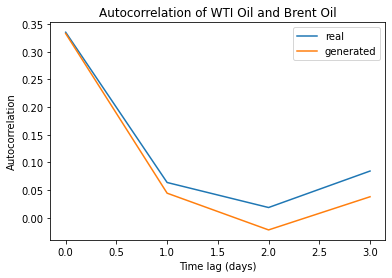

In [19]:
#Generate autocorrelation features from synthetic and real data and plot!
synthetic_acf = get_autocorr(generate_numpy_for_autocorr(df, seq_len))
acf = get_autocorr(generate_numpy_for_autocorr(synthetic_df, seq_len))
# Figure 1, autocorrelation
plt.plot(acf, label="real")
plt.plot(synthetic_acf, label="generated")
plt.xlabel("Time lag (days)")
plt.ylabel("Autocorrelation")
plt.title("Autocorrelation of WTI Oil and Brent Oil")
plt.legend()
plt.show()